# RBI LLM Fine-Tuning

This notebook contains the code for fine-tuning a language model on RBI (Reserve Bank of India) banking regulations and circulars. The model will be trained to answer questions related to Indian banking regulations.

## Setup and Imports

Importing necessary libraries and setting up environment variables.

In [1]:
# !pip install transformers hf_transfer datasets peft matplotlib bitsandbytes

In [2]:
# pip install flash-attn --no-build-isolation

In [3]:
# pip uninstall accelerate -y

In [4]:
# pip install git+https://github.com/huggingface/accelerate.git

In [5]:
import torch
import torch.nn as nn
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig,
    EarlyStoppingCallback
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import matplotlib.pyplot as plt
import os
# from rich import print
# from dotenv import load_dotenv
# load_dotenv()

In [6]:
MODEL_NAME = "Qwen/Qwen2.5-3B-Instruct"
MODEL_PATH = "./Models"
MODEL_OUTPUT_DIR = "./Models/Qwen2.5-3B-Instruct-RBI-QA"
DATASET_NAME = "Vishva007/RBI-Circular-QA-Dataset"
MODEL_ADOPTOR_REPO_ID = "Vishva007/Qwen2.5-3B-Instruct-RBI-QA-Adoptor"
SEED = 42# type: ignore

In [7]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
os.environ['HF_HUB_ENABLE_HF_TRANSFER'] = '1'
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [8]:
if not torch.cuda.is_available():
    print("CUDA not available, using CPU. This will be very slow.")
    device_map = "cpu"
else:
    device_map = "auto"
    print("GPU is Used!")

GPU is Used!


In [9]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True, trust_remote_code=True,cache_dir=MODEL_PATH)
print(f"Before : {tokenizer.pad_token}")
tokenizer.pad_token = tokenizer.eos_token  # Set pad token if it's missing
tokenizer.padding_side = "left"  # IMPORTANT: Set padding_side to 'left' BEFORE tokenizing
print(f"After : {tokenizer.pad_token}")

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Before : <|endoftext|>
After : <|im_end|>


## Dataset Preparation

Loading and preparing the dataset containing RBI circulars and question-answer pairs.

In [10]:
dataset = load_dataset(DATASET_NAME, split="train[:5000]") # type: ignore
print(f"Dataset loaded with {len(dataset)} samples.") # type: ignore
print(dataset)

Dataset loaded with 5000 samples.
Dataset({
    features: ['document', 'filename', 'model_name', 'regulation_area', 'applicable_to', 'issued_on', 'key_topics', 'chunks_text', 'is_table', 'question', 'answer', 'evaluation_criteria', 'category', 'estimated_difficulty', 'rephrased_question', 'rephrased_answer'],
    num_rows: 5000
})


In [11]:
sys_prompt = """
You are a highly knowledgeable AI assistant with expertise in Indian banking and financial regulations, 
particularly those outlined in Reserve Bank of India (RBI) circulars.
Your task is to answer questions based on the RBI circulars and related financial regulations.
"""

def format_data(sample):
    messages = [
        {"role": "system", "content": sys_prompt},
        {"role": "user", "content": sample["question"]},
        {"role": "assistant", "content": sample["answer"]}
    ]
    # apply_chat_template will convert the list of messages into a single string
    # for the model input, adding control tokens like <s> and </s> if the model
    # supports them. `tokenize=False` ensures it returns a string, not token IDs.
    formatted_prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)
    return {"text": formatted_prompt}

In [12]:
dataset = dataset.map(format_data).filter(lambda x: x is not None and x["text"] is not None)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [13]:
print(dataset[5]['text'])

<|im_start|>system

You are a highly knowledgeable AI assistant with expertise in Indian banking and financial regulations, 
particularly those outlined in Reserve Bank of India (RBI) circulars.
Your task is to answer questions based on the RBI circulars and related financial regulations.
<|im_end|>
<|im_start|>user
What is the procedure for handling foreign investment reporting delays exceeding three years?<|im_end|>
<|im_start|>assistant
When forms are filed with a delay greater than three years regarding foreign investment reporting, the AD bank will approve the forms subject to compounding of contravention, after which the applicant may approach the RBI with their application for compounding.<|im_end|>



In [14]:
def tokenize_function(examples):
    # Tokenize the texts with padding and truncation
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)


In [15]:
tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=['document', 'filename', 'model_name', 'regulation_area', 'applicable_to', 'issued_on', 'key_topics',
'chunks_text', 'is_table', 'question', 'answer', 'evaluation_criteria', 'category', 'estimated_difficulty', 
'rephrased_question', 'rephrased_answer','text'],
)


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [16]:
# tokenized_dataset[0] # type: ignore

In [17]:
train_test_split = tokenized_dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = train_test_split["train"]
eval_dataset = train_test_split["test"]

In [18]:
print(f"Formatted dataset with {len(dataset)} samples.")
print(dataset[0])
print(f"Train dataset size: {len(train_dataset)}")
print(f"Eval dataset size: {len(eval_dataset)}")

Formatted dataset with 5000 samples.
{'document': 'RBI_2022-2023_160A.P. (DIR Series) Circular No. 22_2023-01-04', 'filename': 'RBI_2022-2023_160A.P. (DIR Series) Circular No. 22_2023-01-04_text_part1.txt', 'model_name': 'models/gemini-2.0-flash', 'regulation_area': 'Foreign Investment in India', 'applicable_to': 'All Category-I Authorised Dealer Banks', 'issued_on': '2023-01-04', 'key_topics': ['Rationalisation of reporting in Single Master Form (SMF) on FIRMS Portal', 'Auto-acknowledgement of SMF in FIRMS', 'Online calculation of LSF', 'Late Submission Fee (LSF)'], 'chunks_text': '![](_page_0_Picture_0.jpeg)\n\n![](_page_0_Picture_1.jpeg)\n\n![](_page_0_Picture_2.jpeg)\n\nRBI/2022-23/160 A.P. (DIR Series) Circular No. 22 January 04, 2023\n\nTo All Category-I Authorised Dealer Banks\n\nMadam / Sir\n\n## **Foreign Investment in India - Rationalisation of reporting in Single Master Form (SMF) on FIRMS Portal**\n\nAttention of Authorised Dealer Category-I banks (AD banks) is invited to [

## Model Configuration

Configuring the model architecture and tokenizer for fine-tuning.

In [19]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

In [20]:
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype="auto",
    device_map="auto",
    trust_remote_code=True,
    cache_dir=MODEL_PATH,
    quantization_config=quantization_config
)
print(model)

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.6k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 2048)
    (layers): ModuleList(
      (0-35): 36 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=True)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=True)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((2048,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((2048,), 

## Training Configuration

Setting up the training parameters and callbacks for model fine-tuning.

In [21]:
# Assuming these are defined elsewhere in your context, similar to the image
CANDIDATE_ATTRS = ["model", "transformer", "decoder"]

def unwrap_to_base(model):
    for attr in CANDIDATE_ATTRS:
        if hasattr(model, attr):
            return getattr(model, attr)
    raise AttributeError(
        f"Could not find base model (e.g., model, transformer, decoder) "
        f"in {type(model).__name__}. Check CANDIDATE_ATTRS or inspect manually."
    )

def print_model_dimensions(model):
    """
    Prints the dimensions of individual Attention (q, k, v, o) and MLP (gate, up, down)
    layers based on the Qwen2 model structure.
    """
    base = unwrap_to_base(model)
    if not hasattr(base, 'layers') or not base.layers:
        raise ValueError("Model base does not have 'layers' attribute or layers are empty.")

    L0 = base.layers[0] # First decoder layer

    # --- ATTENTION ---
    print("ATTENTION")
    sa = L0.self_attn

    # Print individual q_proj, k_proj, v_proj, o_proj
    for name in ["q_proj", "k_proj", "v_proj", "o_proj"]:
        proj_module = getattr(sa, name, None)
        if isinstance(proj_module, nn.Linear):
            weight_shape = torch.Size([proj_module.out_features, proj_module.in_features]) # type: ignore
            print(f"{name:<10}: torch.Size({list(weight_shape)})")
        else:
            print(f"{name:<10}: Not a Linear module or missing.")


    # --- MLP ---
    print("\nMLP")
    mlp = L0.mlp

    # Print individual gate_proj, up_proj, down_proj
    for name in ["gate_proj", "up_proj", "down_proj"]:
        proj_module = getattr(mlp, name, None)
        if isinstance(proj_module, nn.Linear):
            weight_shape = torch.Size([proj_module.out_features, proj_module.in_features]) # type: ignore
            print(f"{name:<10}: torch.Size({list(weight_shape)})")
        else:
            print(f"{name:<10}: Not a Linear module or missing.")

In [22]:
print_model_dimensions(model)

ATTENTION
q_proj    : torch.Size([2048, 2048])
k_proj    : torch.Size([256, 2048])
v_proj    : torch.Size([256, 2048])
o_proj    : torch.Size([2048, 2048])

MLP
gate_proj : torch.Size([11008, 2048])
up_proj   : torch.Size([11008, 2048])
down_proj : torch.Size([2048, 11008])


In [23]:
model = prepare_model_for_kbit_training(model)

In [25]:
lora_config = LoraConfig(
    r=24,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    use_rslora=True,
    target_modules=[
        # "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
)

In [26]:
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 41,361,408 || all params: 3,127,300,096 || trainable%: 1.3226


In [27]:
import torch

def create_data_collator_for_chat_training(tokenizer):
    """
    Creates a data collator that masks labels to -100 except for the assistant's response.
    This version is more robust for chat-formatted data by directly using tokenized sequences
    for identifying turns.

    Args:
        tokenizer: The tokenizer used for encoding the data, expecting chat template support.

    Returns:
        A DataCollatorForLanguageModeling instance with custom label masking.
    """
    class CustomDataCollator(DataCollatorForLanguageModeling):
        def torch_call(self, features): # type: ignore
            # Pad inputs to the longest sequence in the batch
            # padding="max_length" is generally good if you've already set it in tokenization
            # Otherwise, padding=True for dynamic padding to the longest in the batch
            batch = self.tokenizer.pad(
                features,
                return_tensors="pt",
                padding=True, # Dynamically pad to the longest sequence in the batch
            )

            # batch = {key: torch.stack([f[key] for f in features]) for key in features[0].keys()} If you don't need padding use this line.

            labels = batch["input_ids"].clone() # type: ignore

            # Define the exact token sequences for start/end of assistant's turn
            # These are specific to Qwen's chat template tokenization
            # <|im_start|>assistant\n  -> [151644, 872, 198]
            # <|im_end|>                  -> [151645]

            # Use tokenizer.encode to get the exact token IDs for the prompts
            # This is more reliable than guessing individual token IDs for subwords/special chars
            assistant_prompt_ids = self.tokenizer.encode("<|im_start|>assistant\n", add_special_tokens=False, return_tensors="pt")[0]
            im_end_token_id = self.tokenizer.convert_tokens_to_ids("<|im_end|>") # type: ignore # This one is a known special token

            for i, input_ids_tensor in enumerate(batch["input_ids"]): # type: ignore
                # Initialize all labels to -100 (ignore by default)
                labels[i, :] = -100

                # Convert input_ids_tensor to a standard Python list for easier slicing/comparison
                # This makes the search part simpler if you prefer list operations.
                # However, for efficiency with large tensors, keeping it as tensor is better.
                # Let's stick to tensor operations for robustness and performance.

                # Find the start of the assistant's response within the current sequence
                assistant_start_idx = -1

                # Iterate through the input_ids to find the sequence `assistant_prompt_ids`
                # We need to use tensor comparison here.
                len_prompt = len(assistant_prompt_ids) # type: ignore
                for j in range(len(input_ids_tensor) - len_prompt + 1):
                    if torch.equal(input_ids_tensor[j : j + len_prompt], assistant_prompt_ids.to(input_ids_tensor.device)): # type: ignore
                        assistant_start_idx = j + len_prompt # Start of the actual response
                        break # Found the first occurrence of assistant turn

                # Find the corresponding end of the assistant's turn (<|im_end|>)
                assistant_end_idx = -1
                if assistant_start_idx != -1:
                    # Search for im_end_token_id ONLY AFTER the assistant's prompt start
                    for j in range(assistant_start_idx, len(input_ids_tensor)):
                        if input_ids_tensor[j] == im_end_token_id:
                            assistant_end_idx = j
                            break

                # If the assistant's response part is successfully identified, unmask it
                # Ensure start is before end and both are valid indices
                if (assistant_start_idx != -1 and
                    assistant_end_idx != -1 and
                    assistant_start_idx < assistant_end_idx):

                    labels[i, assistant_start_idx : assistant_end_idx] = input_ids_tensor[assistant_start_idx : assistant_end_idx]

                # Handle cases where the sequence is truncated and assistant_end_idx might be beyond max_length
                # In such cases, if assistant_start_idx is found, but end is not (due to truncation),
                # we should still train on the available part of the assistant's response until max_length.
                elif assistant_start_idx != -1 and assistant_end_idx == -1:
                     labels[i, assistant_start_idx:] = input_ids_tensor[assistant_start_idx:]


            batch["labels"] = labels
            return batch

    return CustomDataCollator(tokenizer=tokenizer, mlm=False)

In [28]:
data_collator = create_data_collator_for_chat_training(tokenizer)


In [29]:
sample_to_check = eval_dataset[0]
print(f"Original tokenized sample (eval_dataset[0]): {sample_to_check}")

# Manually call the data collator with this single sample (wrapped in a list for batching)
collated_sample = data_collator([sample_to_check])


You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Original tokenized sample (eval_dataset[0]): {'input_ids': [151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 1516

In [30]:

print("\n--- Debugging Collated Sample ---")
print("Input IDs:", collated_sample["input_ids"])
print("Labels:", collated_sample["labels"])

# Decode the labels to visually check masking
decoded_labels = collated_sample["labels"][0].clone()
decoded_labels[decoded_labels == -100] = tokenizer.pad_token_id # Replace -100 for decoding
print("Decoded Labels (with masked parts as pad token):", tokenizer.decode(decoded_labels, skip_special_tokens=False))

# Also, let's decode the original input_ids to compare
print("Decoded Input IDs:", tokenizer.decode(collated_sample["input_ids"][0], skip_special_tokens=False))



--- Debugging Collated Sample ---
Input IDs: tensor([[151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645,
         151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645,
         151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645,
         151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645,
         151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645,
         151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645,
         151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645,
         151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645,
         151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645,
         151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645,
         151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645, 151645,
         151645, 151645, 151645, 151645, 151645, 151645, 151645

In [36]:
training_args = TrainingArguments(
    output_dir=MODEL_OUTPUT_DIR,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,  # Keep at 1
    gradient_accumulation_steps=4,  # Increased to maintain batch size
    max_steps=200,
    learning_rate=2e-4,  # Slightly reduced learning rate
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    num_train_epochs=1,  # Reduced from 3 to 2
    fp16=True,
    eval_strategy="steps",
    eval_steps=10,  # Increased eval steps to reduce frequency
    save_strategy="steps",
    save_steps=10,
    load_best_model_at_end=False,  # Disabled to save memory
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    push_to_hub=False,
    remove_unused_columns=False,
    logging_dir="./logs",
    logging_steps=10,
    report_to="tensorboard",
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},
    dataloader_pin_memory=False,  # Disable pin memory to save GPU memory
    dataloader_num_workers=0,     # Use single worker to save memory
    max_grad_norm=1.0,           # Add gradient clipping
    group_by_length=False,       # Disable to save memory
    length_column_name=None, 
    eval_accumulation_steps=1, # Set to 1 to avoid memory issues during evaluation
)

In [ ]:
# pip install tensorboard
# cd ../workspace
# tensorboard --logdir ./logs --host 0.0.0.0 --port 6006 --reload_interval 5

# https://[pod_id]-6006.proxy.runpod.net/

In [38]:
# 7. Initialize the Trainer
trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    args=training_args,
    data_collator=data_collator,
    # compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [39]:
train_result = trainer.train()

Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Step,Training Loss,Validation Loss
10,1.589100,1.557521
20,1.426500,1.423575
30,1.359200,1.307837
40,1.185700,1.221586
50,1.209000,1.143734
60,1.078000,1.079428
70,1.071600,1.027418
80,1.026700,0.981359
90,0.932300,0.949844
100,0.870200,0.912790


config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

In [40]:
model.save_pretrained(MODEL_OUTPUT_DIR) # type: ignore

## Model Evaluation

Evaluating the fine-tuned model's performance.

In [41]:
train_history = train_result.metrics
eval_history = trainer.evaluate()

In [42]:
final_eval_loss = eval_history.get("eval_loss")

if final_eval_loss is not None:
    final_perplexity = torch.exp(torch.tensor(final_eval_loss)).item()
    print(f"Final Evaluation Loss: {final_eval_loss:.4f}")
    print(f"Final Perplexity: {final_perplexity:.2f}")


Final Evaluation Loss: 0.8010
Final Perplexity: 2.23


Loss plot saved to ./loss_plot.png


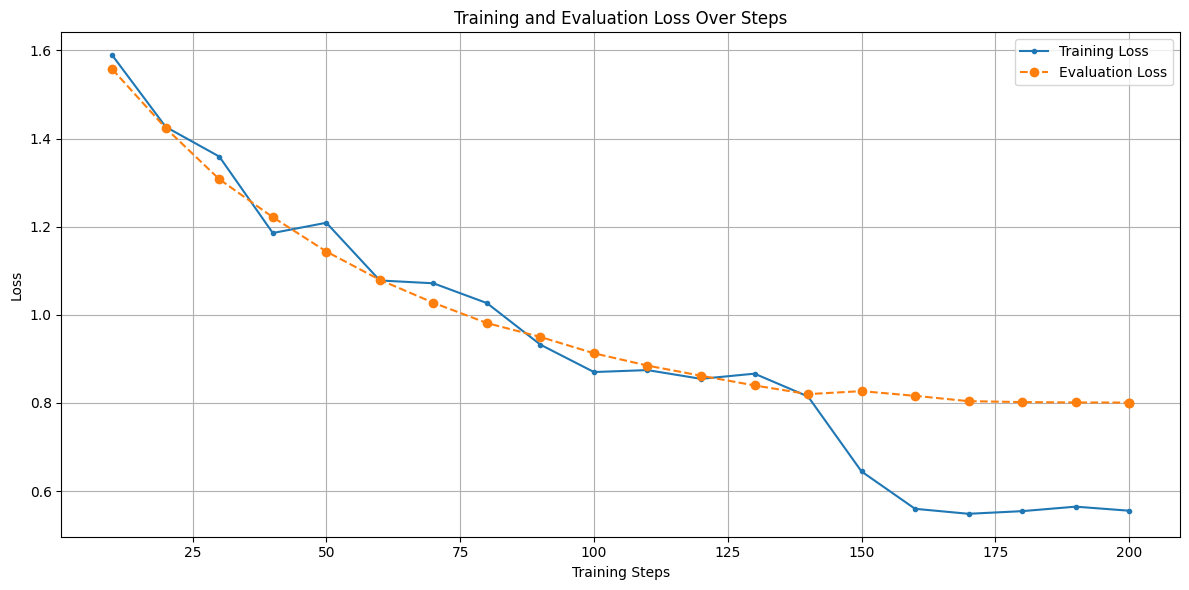

In [43]:
# --- 11. Extracting Metrics from log_history for Plotting ---
train_losses = []
eval_losses = []
eval_steps = [] # Store steps where evaluation occurred

# Iterate through the trainer's log_history
for log in trainer.state.log_history:
    # Training loss is logged at 'logging_steps' intervals
    if "loss" in log and "learning_rate" in log: # Check if it's a training step log
        train_losses.append({"step": log["step"], "loss": log["loss"]})
    # Evaluation loss is logged at 'eval_steps' intervals
    if "eval_loss" in log:
        eval_losses.append({"step": log["step"], "loss": log["eval_loss"]})

# Prepare data for plotting
train_steps_plot = [entry["step"] for entry in train_losses]
train_values_plot = [entry["loss"] for entry in train_losses]

eval_steps_plot = [entry["step"] for entry in eval_losses]
eval_values_plot = [entry["loss"] for entry in eval_losses]

# --- 12. Plotting the Training and Evaluation Loss ---
plt.figure(figsize=(12, 6))
plt.plot(train_steps_plot, train_values_plot, label="Training Loss", marker='.')
plt.plot(eval_steps_plot, eval_values_plot, label="Evaluation Loss", marker='o', linestyle='--')

plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss Over Steps")
plt.legend()
plt.grid(True)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plot_path = os.path.join("./", "loss_plot.png")
plt.savefig(plot_path)
print(f"Loss plot saved to {plot_path}")
plt.show()

In [45]:
from huggingface_hub import notebook_login

notebook_login()

In [46]:

model.push_to_hub(MODEL_ADOPTOR_REPO_ID)  # type: ignore

tokenizer.push_to_hub(MODEL_ADOPTOR_REPO_ID)

print(f"LoRA adapters pushed to https://huggingface.co/{MODEL_ADOPTOR_REPO_ID}")

  0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

LoRA adapters pushed to https://huggingface.co/Vishva007/Qwen2.5-3B-Instruct-RBI-QA-Adoptor
